# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from sklearn.metrics import silhouette_score
from tqdm import tqdm

import umap

sc.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.set_figure_params(frameon=False, color_map='magma_r')

import splicing_utils


-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.0
anndata             0.7.4
autoreload          NA
backcall            0.2.0
cffi                1.14.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
joblib              0.17.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.34.0
louvain             0.7.0
matplotlib          3.3.2
mpl_toolkits        NA
natsort             7.0.1
numba               0.51.2
numexpr             2.7.1
numpy               1.19.2
packaging           20.4
pandas              1.1.3
parso               0.7.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
ptyprocess          0.6.0
pycparser           2.20
pygments            2.7.1
pyparsin

## Data folder

In [2]:
splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13'
! ls -lha $splicing_folder

total 1.5G
drwxr-xr-x 3 olga czb 4.0K Oct 13 11:04 .
drwxr-xr-x 7 olga czb 4.0K Oct 13 10:48 ..
drwxr-xr-x 2 olga czb 4.0K Oct 13 11:05 concatenated
-rw-r--r-- 1 olga czb 690M Oct 13 10:15 TSP1_10x_nopanc_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 803M Oct 13 10:14 TSP2_10x_3prime_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq


## 2d splicing data

In [3]:
concatenated_splicing_folder = f'{splicing_folder}/concatenated'
! ls -lha  $concatenated_splicing_folder

total 699M
drwxr-xr-x 2 olga czb 4.0K Oct 13 11:05 .
drwxr-xr-x 3 olga czb 4.0K Oct 13 11:04 ..
-rw-r--r-- 1 olga czb  21M Oct 13 11:05 tabula_sapiens_10x_splicing_2d.parquet
-rw-r--r-- 1 olga czb 679M Oct 13 11:05 tabula_sapiens_10x_splicing_tidy.parquet


## Read h5ad

### Try new adata

In [4]:
# h5ad = '/home/olga/Pilot1_Pilot2_filtered_ensembl_id_Aug5.ss2_norm.ann.compartment.allgenes.h5ad'

# Newest, freshest data
h5ad2 = '/home/olga/data_sm/tabula-sapiens/data-objects/Pilot1_Pilot2.decontX.h5ad'
adata = sc.read(h5ad2)
adata

AnnData object with n_obs × n_vars = 150084 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_metho

### Clean to only 10x data and clean the cell id

In [5]:
adata_10x = adata[adata.obs.method == "10X"]
adata_10x.obs = adata_10x.obs.set_index('cell_id')
adata_10x.obs.head()

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAGTGTAGCAG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.014378,TSP110X-macrophage,NaN,NaN,0.000493,2,0,9.285843,0.678913
AAACCCATCAAGTCTG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.087799,TSP110X-macrophage,NaN,NaN,0.001835,2,0,9.285843,0.678913
AAACCCATCCTTCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.015747,TSP110X-macrophage,NaN,NaN,0.000560,2,0,9.285843,0.678913
AAACCCATCGAAGGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.006901,TSP110X-macrophage,NaN,NaN,0.000383,2,0,9.285843,0.678913
AAACGAAAGCTCCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.460883,TSP110X-plasma cell,NaN,NaN,0.017516,2,0,9.285843,0.678913


## Read 2d splicing matrix

In [6]:
splicing2d = pd.read_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_10x_splicing_2d.parquet')
# Update cell ids
# splicing2d.index = splicing2d.index.str.rstrip('_0123456789')
print(splicing2d.shape)
splicing2d.head()

(59367, 1617)


geneR1A_uniq,A2M,AAMDC,AARSD1,ABCA6,ABI3BP,AC005062.2,AC006369.2,AC011513.3,AC012146.7,AC013264.2,...,ZNF706,ZNRF1,ZRSR2,snoU13,uc_338,unknown_chr17_68100000,unknown_chr19_15900000,unknown_chr2_145700000,unknown_chr4_73800000,unknown_chr9_76500000
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
adata_10x.obs.head()

,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAGTGTAGCAG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.014378,TSP110X-macrophage,NaN,NaN,0.000493,2,0,9.285843,0.678913
AAACCCATCAAGTCTG_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.087799,TSP110X-macrophage,NaN,NaN,0.001835,2,0,9.285843,0.678913
AAACCCATCCTTCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.015747,TSP110X-macrophage,NaN,NaN,0.000560,2,0,9.285843,0.678913
AAACCCATCGAAGGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.006901,TSP110X-macrophage,NaN,NaN,0.000383,2,0,9.285843,0.678913
AAACGAAAGCTCCGAC_TSP1_bladder_1,TSP1_bladder_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.460883,TSP110X-plasma cell,NaN,NaN,0.017516,2,0,9.285843,0.678913


## Get a comon indx of shared cells

In [8]:
common_index = splicing2d.index.intersection(adata_10x.obs.index)
len(common_index)

52697

### Subset the adata

In [9]:
adata_with_splicing = adata_10x[common_index]
print(adata_with_splicing)
adata_with_splicing.obs.head()

View of AnnData object with n_obs × n_vars = 52697 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', 

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,TSP1_muscle_2,nan,nan,nan,nan,nan,10X,TSP1,2,novaseq,...,TSP110X,0.010015,TSP110X-skeletal muscle satellite stem cell,NaN,NaN,0.000411,2,0,9.285843,0.678913
AAACCCAAGCAACAGC_TSP1_blood_3,TSP1_blood_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.004977,TSP110X-T cell,NaN,NaN,0.000356,2,0,9.285843,0.678913
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,TSP2_Blood_NA_10X_2_1,nan,nan,nan,nan,nan,10X,TSP2,1,novaseq,...,TSP210X,0.055971,TSP210X-natural killer cell,NaN,NaN,0.001357,3,0,8.848207,0.482012
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,TSP2_Blood_NA_10X_1_3,nan,nan,nan,nan,nan,10X,TSP2,3,novaseq,...,TSP210X,0.002236,TSP210X-non-classical monocyte,NaN,NaN,0.000100,3,0,8.848207,0.482012
AAACCCAAGCATCAGG_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.001521,TSP110X-macrophage,NaN,1.0,0.000165,2,0,9.285843,0.678913


### Subset the splicing data

In [10]:
splicing2d_common = splicing2d.loc[common_index]
print(splicing2d_common.shape)
splicing2d_common

(52697, 1617)


geneR1A_uniq,A2M,AAMDC,AARSD1,ABCA6,ABI3BP,AC005062.2,AC006369.2,AC011513.3,AC012146.7,AC013264.2,...,ZNF706,ZNRF1,ZRSR2,snoU13,uc_338,unknown_chr17_68100000,unknown_chr19_15900000,unknown_chr2_145700000,unknown_chr4_73800000,unknown_chr9_76500000
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTATCGGA_TSP2_Lung_proxmedialdistal_10X_1_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCTCATGGA_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCTGAGATC_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Subset to just lung, do donor by donor

In [11]:
adata_with_splicing_lung = adata_with_splicing[
    (adata_with_splicing.obs.tissue == "Lung") & (adata_with_splicing.obs.donor == "TSP1")
]
adata_with_splicing_lung

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 9374 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', '

In [12]:
adata_with_splicing_lung.obs.groupby('donor').size()

donor
TSP1    9374
dtype: int64

In [13]:
splicing2d_lung = splicing2d.loc[adata_with_splicing_lung.obs.index]
splicing2d_lung.shape

(9374, 1617)

## filter splicing data

### Filter on number of cells per gene

count    1617.000000
mean      567.944341
std      1826.308936
min         0.000000
25%         0.000000
50%         1.000000
75%        39.000000
max      9327.000000
dtype: float64


/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

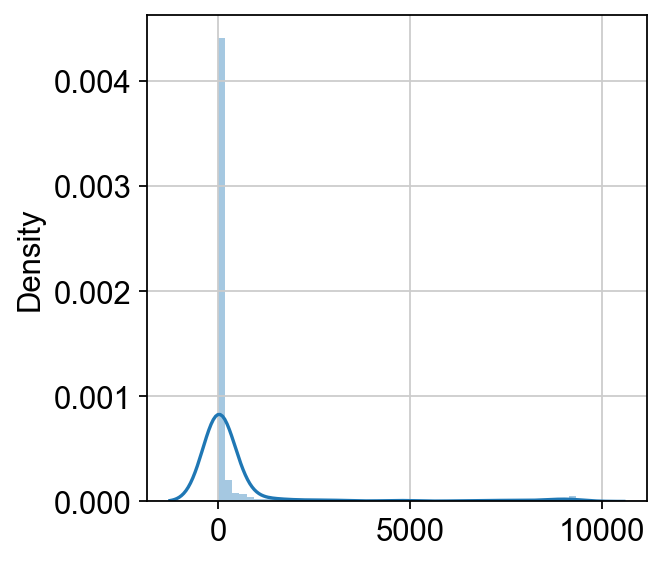

In [14]:
n_cells_per_gene = splicing2d_lung.notnull().sum()
print(n_cells_per_gene.describe())
sns.distplot(n_cells_per_gene)

count    9374.000000
mean       97.969490
std        32.743316
min         1.000000
25%        77.250000
50%        97.000000
75%       116.000000
max       328.000000
dtype: float64


/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

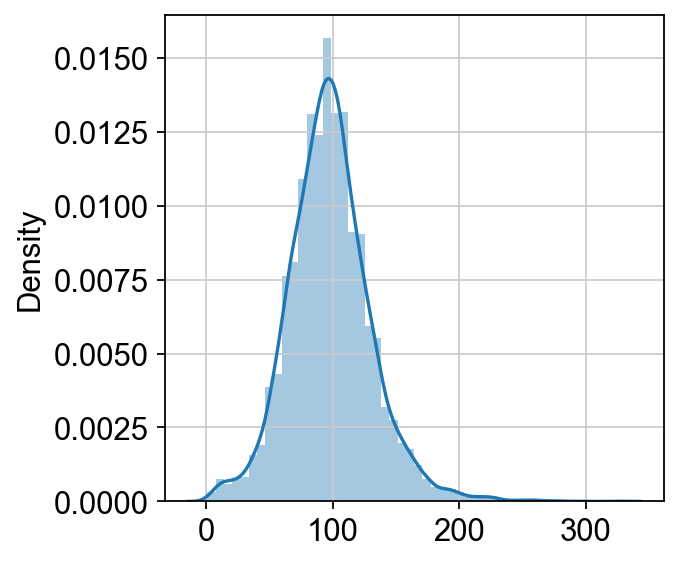

In [15]:
n_genes_per_cell = splicing2d_lung.notnull().sum(axis=1)
print(n_genes_per_cell.describe())
sns.distplot(n_genes_per_cell)

In [16]:
splicing2d_lung_min_genes_cells = splicing2d_lung.loc[n_genes_per_cell >= 75, n_cells_per_gene >= 100]
splicing2d_lung_min_genes_cells.shape

(7320, 329)

## Make sure important genes are present

In [67]:
gene_subset = ['CAST', #'ATP5F1C', 'CALD', 
               'ATP5C1',
               'MYL6', 'CD47', 
               'PFDN5']

In [18]:
# splicing2d[gene_subset]

In [77]:
splicing2d_lung_subset = splicing2d_lung[gene_subset]
splicing2d_lung_subset = splicing2d_lung_subset.loc[splicing2d_lung_subset.notnull().sum(axis=1) >= 2, :]
print(splicing2d_lung_subset.shape)
splicing2d_lung_subset.head()

(4562, 5)


geneR1A_uniq,CAST,ATP5C1,MYL6,CD47,PFDN5
cell_id,,,,,
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,0.547840,NaN,-0.143995
AAACCCACAACTCGTA_TSP1_lung_2,NaN,NaN,0.307766,NaN,-0.095480
AAACCCACAAGTTCGT_TSP1_lung_3,NaN,NaN,0.610640,NaN,-0.071191
AAACCCACACTGGCGT_TSP1_lung_1,NaN,-0.059049,0.421307,NaN,0.286456
AAACCCAGTCCGACGT_TSP1_lung_2,NaN,0.039564,0.230403,NaN,NaN


## Subset adata to only cells with enough splicing

In [78]:
adata_with_splicing_subset = adata_with_splicing_lung[splicing2d_lung_subset.index]
adata_with_splicing_subset

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 4562 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', '

## SKIP - Subsample to 50% of data

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


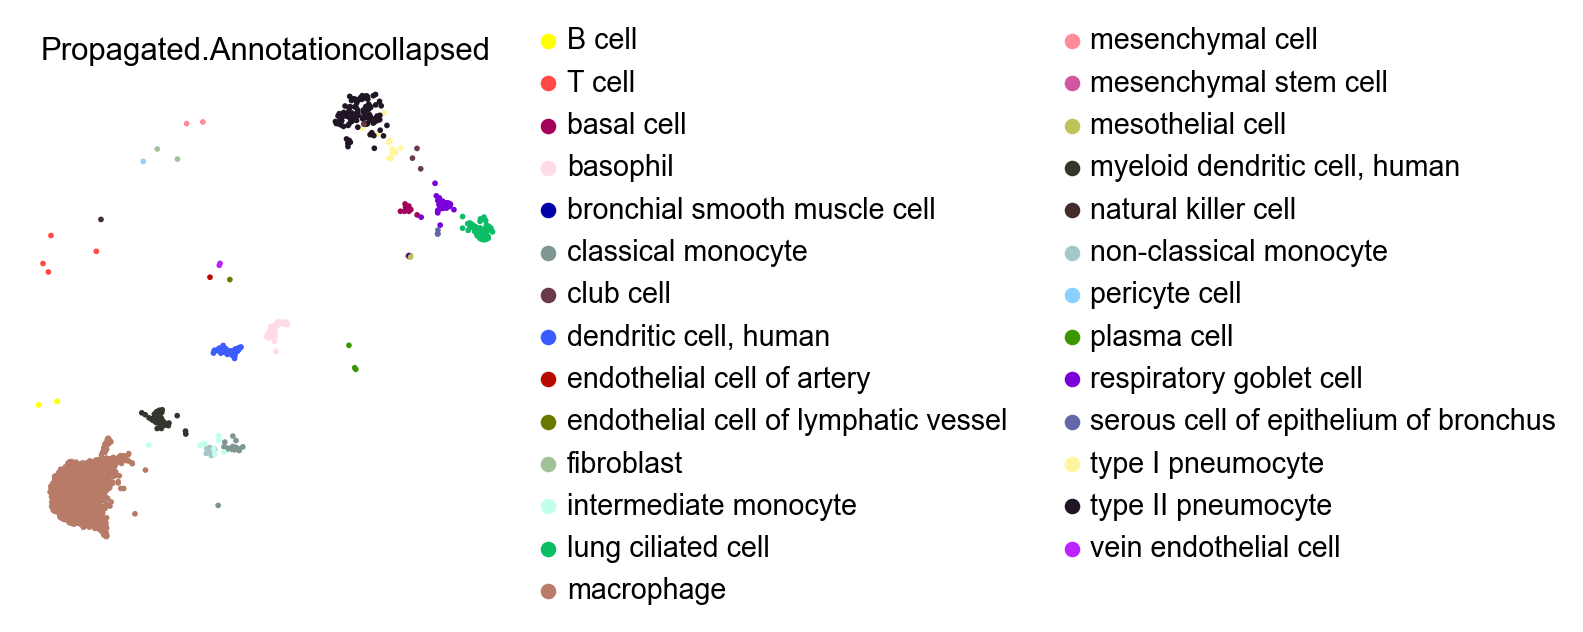

In [79]:
# splicing2d_muscle_min_genes_cells_subset = splicing2d_muscle_min_genes_cells.sample(frac=0.5)
# splicing2d_subset.shape
sc.pl.umap(adata_with_splicing_subset, color='Propagated.Annotationcollapsed')

In [82]:
adata_with_splicing_subset.obs.groupby(['donor', 'tissue', 'Propagated.Annotationcollapsed']).size()

donor  tissue  Propagated.Annotationcollapsed       
TSP1   Lung    B cell                                      2
               T cell                                      4
               basal cell                                  9
               basophil                                   85
               bronchial smooth muscle cell                1
               classical monocyte                         16
               club cell                                   4
               dendritic cell, human                     107
               endothelial cell of artery                  1
               endothelial cell of lymphatic vessel        1
               fibroblast                                  2
               intermediate monocyte                       9
               lung ciliated cell                         93
               macrophage                               3971
               mesenchymal cell                            5
               mesenchymal stem 

In [83]:
celltypes_to_test = ["macrophage", "type II pneumocyte"]
filtered_celltypes = adata_with_splicing_subset.obs['Propagated.Annotationcollapsed'].isin(celltypes_to_test)

In [101]:
filtered_adata_with_splicing_subset = adata_with_splicing_subset[filtered_celltypes]
filtered_adata_with_splicing_subset

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 4079 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', '

In [96]:
filtered_sample = filtered_adata_with_splicing_subset.obs.groupby(
    ['Propagated.Annotationcollapsed'], observed=True, group_keys=False).apply(lambda x: x.sample(108, random_state=0))
print(filtered_sample.shape)
filtered_sample.head()

(216, 60)


,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,...,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
cell_id,,,,,,,,,,,,,,,,,,,,,
CTAGACATCACGTCCT_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.000917,TSP110X-macrophage,NaN,NaN,0.000099,2,0,9.285843,0.678913
TCCTAATGTTCTTGTT_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.003328,TSP110X-macrophage,NaN,1.0,0.000240,2,0,9.285843,0.678913
CTGTATTAGGGACTGT_TSP1_lung_1,TSP1_lung_1,nan,nan,nan,nan,nan,10X,TSP1,1,novaseq,...,TSP110X,0.003847,TSP110X-macrophage,NaN,1.0,0.000374,2,0,9.285843,0.678913
GATGAGGGTAGAAACT_TSP1_lung_2,TSP1_lung_2,nan,nan,nan,nan,nan,10X,TSP1,2,novaseq,...,TSP110X,0.002601,TSP110X-macrophage,NaN,1.0,0.000377,2,0,9.285843,0.678913
TAGGTACCATATACCG_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,10X,TSP1,3,novaseq,...,TSP110X,0.002001,TSP110X-macrophage,NaN,1.0,0.000285,2,0,9.285843,0.678913


In [103]:
filtered_adata_with_splicing_subset.obs['Propagated.Annotationcollapsed'].value_counts()

macrophage            3971
type II pneumocyte     108
Name: Propagated.Annotationcollapsed, dtype: int64

In [105]:
splicing_lung_cell_subset = splicing2d_lung_subset.loc[filtered_adata_with_splicing_subset.obs.index]
print(splicing_lung_cell_subset.shape)
splicing_lung_cell_subset.head()

(4079, 5)


geneR1A_uniq,CAST,ATP5C1,MYL6,CD47,PFDN5
cell_id,,,,,
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,0.547840,NaN,-0.143995
AAACCCACAAGTTCGT_TSP1_lung_3,NaN,NaN,0.610640,NaN,-0.071191
AAACCCACACTGGCGT_TSP1_lung_1,NaN,-0.059049,0.421307,NaN,0.286456
AAACCCAGTCCGACGT_TSP1_lung_2,NaN,0.039564,0.230403,NaN,NaN
AAACCCAGTTCAGTAC_TSP1_lung_2,NaN,NaN,0.157778,NaN,-0.247624


In [110]:
splicing_lung_cell_subset_tidy = splicing_lung_cell_subset.unstack().reset_index()
splicing_lung_cell_subset_tidy = splicing_lung_cell_subset_tidy.rename(columns={0:"z_score"})
splicing_lung_cell_subset_tidy = splicing_lung_cell_subset_tidy.join(filtered_adata_with_splicing_subset.obs["Propagated.Annotationcollapsed"], on="cell_id")
print(splicing_lung_cell_subset_tidy.shape)
splicing_lung_cell_subset_tidy.head()

(20395, 4)


,geneR1A_uniq,cell_id,z_score,Propagated.Annotationcollapsed
0,CAST,AAACCCAAGCATCAGG_TSP1_lung_3,NaN,macrophage
1,CAST,AAACCCACAAGTTCGT_TSP1_lung_3,NaN,macrophage
2,CAST,AAACCCACACTGGCGT_TSP1_lung_1,NaN,macrophage
3,CAST,AAACCCAGTCCGACGT_TSP1_lung_2,NaN,macrophage
4,CAST,AAACCCAGTTCAGTAC_TSP1_lung_2,NaN,macrophage


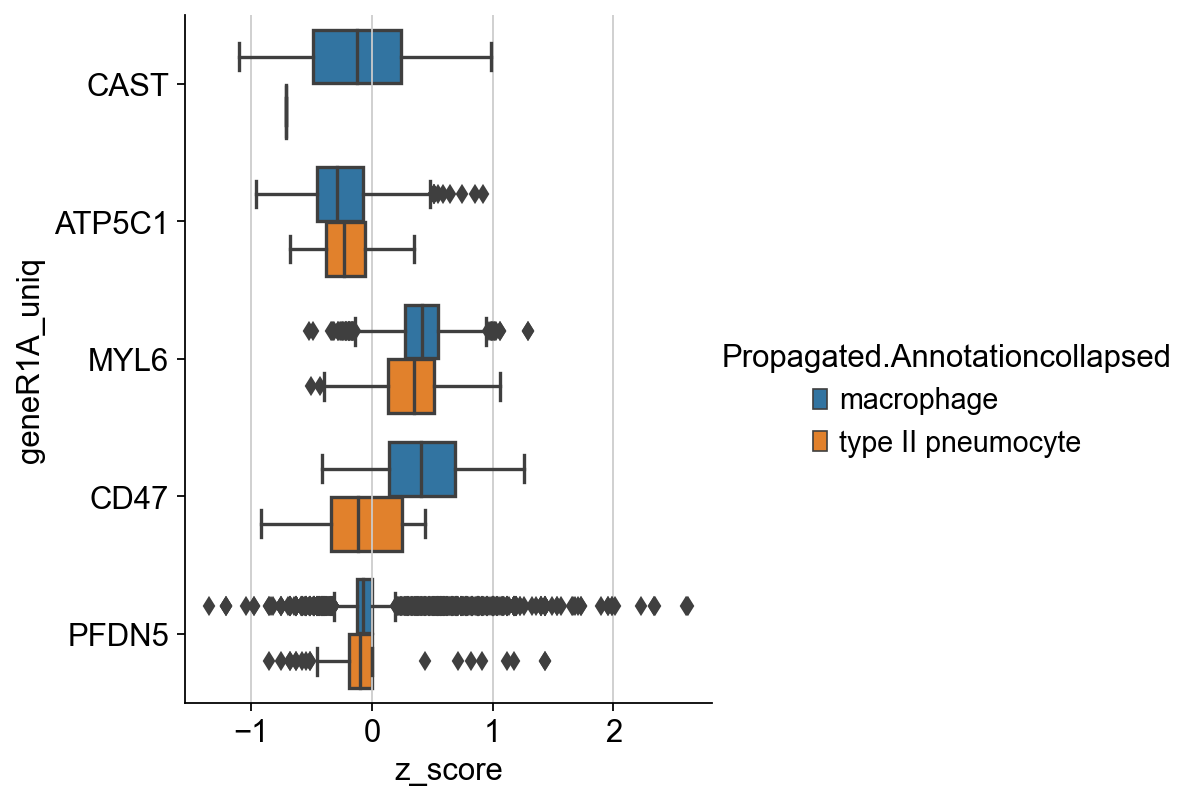

In [111]:
sns.catplot(data=splicing_lung_cell_subset_tidy, y="geneR1A_uniq", x="z_score", hue="Propagated.Annotationcollapsed", kind="box")

In [112]:
adata_with_splicing_subset.obs.groupby(['donor', 'tissue', 'Propagated.Annotationcollapsed'], observed=True).size()

donor  tissue  Propagated.Annotationcollapsed       
TSP1   Lung    macrophage                               3971
               basophil                                   85
               myeloid dendritic cell, human              41
               dendritic cell, human                     107
               type II pneumocyte                        108
               endothelial cell of artery                  1
               lung ciliated cell                         93
               respiratory goblet cell                    62
               type I pneumocyte                          16
               basal cell                                  9
               mesenchymal cell                            5
               non-classical monocyte                     10
               natural killer cell                         1
               B cell                                      2
               classical monocyte                         16
               endothelial cell 

In [ ]:
%%time
import splicing_utils
splicing2d_subset_distances = splicing_utils.compute_distances_df(splicing_lung_cell_subset, n_jobs=32, metric="euclidean")
print(splicing2d_subset_distances.shape)
splicing2d_subset_distances.head()

Created memmapped input matrix
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessingcondsndscomparison for index 2944 done in 0.05955 secondscomparison for index 3968 done in 0.00536 secondscomparison for index 2176 done in 0.08742 secondscomparison for index 3712 done in 0.01660 secondscomparison for index 640 done in 0.13481 secondscomparison for index 3328 done in 0.03970 secondscomparison for index 1152 done in 0.09325 secondscomparison for index 768 done in 0.12564 secondscomparison for index 1920 done in 0.08408 secondscomparison for index 1280 done in 0.10546 secondscomparison for index 1408 done in 0.10676 secondscomparison for index 3584 done in 0.02031 secondscomparison for index 128 done in 0.14374 secondscomparison for index 2560 done in 0.06127 secondscomparison for index 2048 done in 0.08199 secondscomparison for index 384 done in 0.14537 secondscomparison for index 1536 done in 0.10656 secondscomparison for index 3969

# Do UMAP

In [114]:
%%time

umapper = umap.UMAP(metric='precomputed', verbose=True)
umapped = umapper.fit_transform(splicing2d_subset_distances)
umapped.shape

/home/pranathi/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


UMAP(metric='precomputed', verbose=True)
Construct fuzzy simplicial set
Tue Oct 27 16:37:39 2020 Finding Nearest Neighbors
Tue Oct 27 16:37:39 2020 Finished Nearest Neighbor Search
Tue Oct 27 16:37:39 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Oct 27 16:37:56 2020 Finished embedding
CPU times: user 11min 40s, sys: 4min 49s, total: 16min 29s
Wall time: 17.5 s


(4079, 2)

In [115]:
umapped.shape

(4079, 2)

In [117]:
filtered_adata_with_splicing_subset.obsm['X_umap_splicing'] = umapped

## Plot UMAP

In [28]:
# adata_with_splicing_subset.uns['']

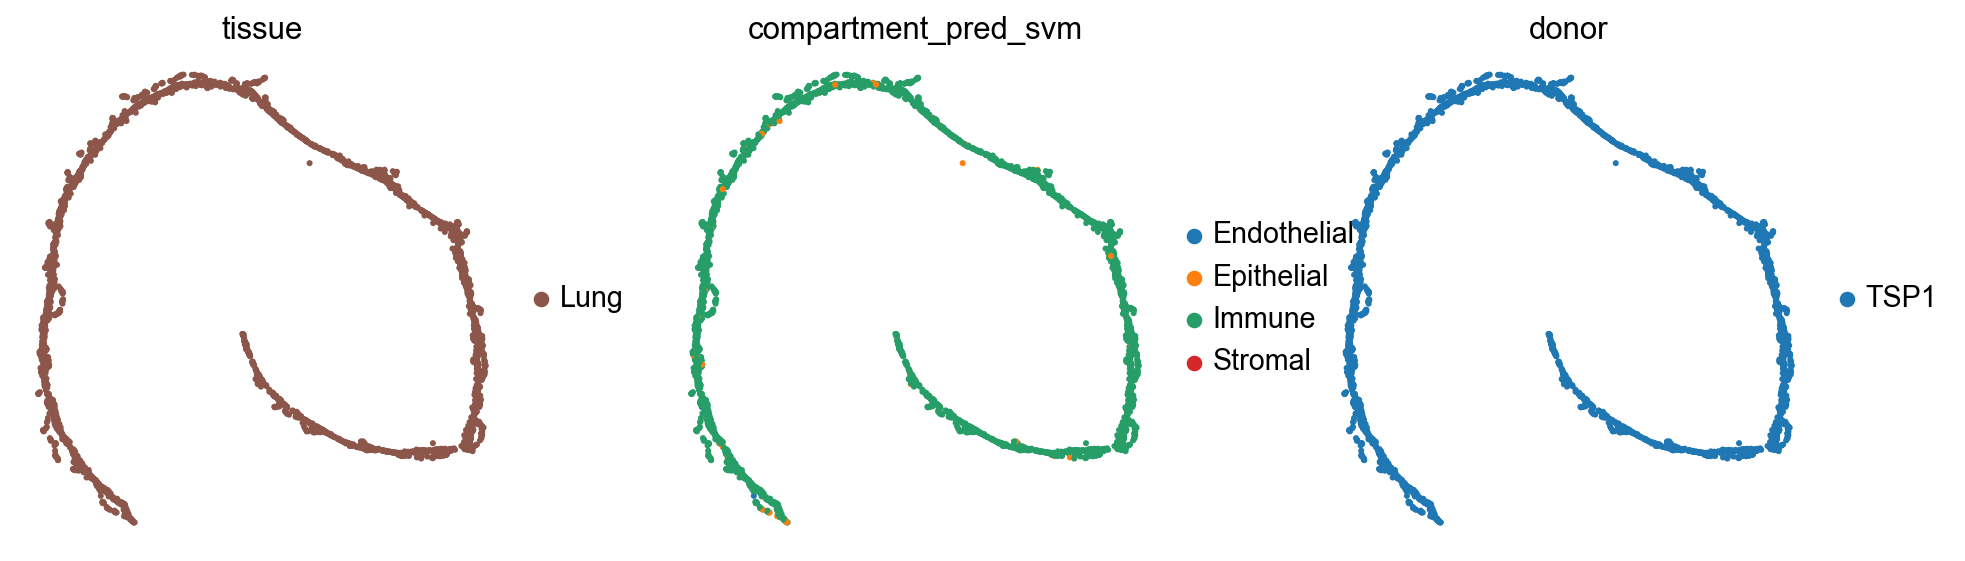

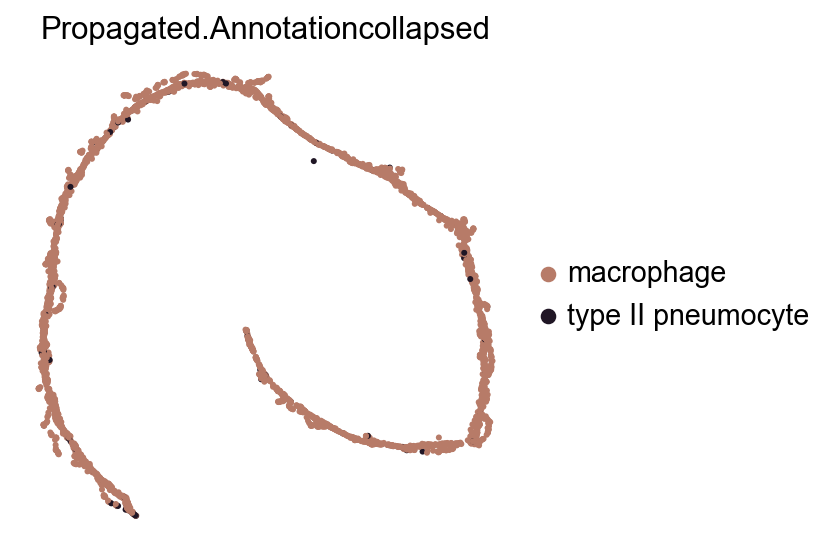

In [119]:
UMAP_COLOR = ['tissue', 'compartment_pred_svm', 'donor']

sc.pl.embedding(filtered_adata_with_splicing_subset, basis='X_umap_splicing', color=UMAP_COLOR)
sc.pl.embedding(filtered_adata_with_splicing_subset, basis='X_umap_splicing', color='Propagated.Annotationcollapsed')

### BBKNN

## BBKNN on expression data

In [30]:
# sc.tl.pca(adata, n_comps=200)

In [31]:
# sc.external.pp.bbknn(adata, batch_key='donor')

## Function to compute silhouette scores

In [32]:
def compute_silhoutte_vs_col(adata, silhouette_cols, umapped, label, metric='euclidean', n_iter=100):
    lines = []
    sample_size = int(umapped.shape[0]/2)
    for i in tqdm(range(n_iter)):
        for col in silhouette_cols: 
            silhouette = silhouette_score(umapped, adata.obs[col], metric=metric, sample_size=sample_size, 
                                          random_state=i)
            lines.append([label, col, silhouette, i])
    df = pd.DataFrame(lines, columns=['label', 'group', 'silhoutte_score', 'iteration'])
    return df

In [33]:
silhouette_cols = UMAP_COLOR + ['Propagated.Annotationcollapsed']

In [34]:
silhouette_cols = ['compartment_pred_svm', 'donor', 'Propagated.Annotationcollapsed']
silhouette_cols

['compartment_pred_svm', 'donor', 'Propagated.Annotationcollapsed']

### Compute silhouette on KNN distances of graph

In [35]:
adata_with_splicing_subset

AnnData object with n_obs × n_vars = 3571 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', 'decontX_

In [36]:
%%time

silhouette_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, 
    adata_with_splicing_subset.obsp['distances'].todense(), 
    label='bbknn_distances', metric='precomputed'
)
silhouette_bbknn

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

### Comput silhouette on splicing distances

In [37]:
%%time

silhouette_splicing = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, splicing2d_subset_distances, label='splicing_distances', metric='precomputed'
)
silhouette_splicing

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [38]:
# %%time

# silhouette_scvi = compute_silhoutte_vs_col(
#     adata_with_splicing_subset, silhouette_cols, adata_with_splicing_subset.obsm['X_scvi'], label='expression_scvi', 
# )
# silhouette_scvi

### SKIP - Calculating on expression values takes too long - can't even complete 1 iteration in a reasonable time (<1h)

In [39]:
# %%time

# silhouette_genes = compute_silhoutte_vs_col(
#     adata_with_splicing_subset, 
#     silhouette_cols, 
#     adata_with_splicing_subset.X, 
#     label='expression_euclidean', 
#     metric='euclidean',
#     n_iter=10,
# )
# silhouette_genes

## Concatenate silhouette scores

In [40]:
silhoutte_concatenated = pd.concat(
    [
        silhouette_splicing, 
#         silhouette_scvi, 
        silhouette_genes
    ]
)
print(silhoutte_concatenated.shape)
silhoutte_concatenated.head()

NameError: name 'silhouette_splicing' is not defined

## Plot silhouette scores

In [ ]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='label',
    col='group',
    data=silhoutte_concatenated,
    kind='box',
)

## Plot silhouette scores

In [ ]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='group',
    col='label',
    data=silhoutte_concatenated,
    kind='box',
)

## bbknn_utils.py

In [ ]:
%%file bbknn_utils.py
from typing import Optional, Union


import numpy as np
from scipy.spatial import cKDTree
import bbknn
from scipy.sparse import csr_matrix
import scanpy as sc
from numpy.testing import assert_array_equal, assert_array_compare
import operator


import numpy as np
from anndata import AnnData
from sklearn.utils import check_random_state, check_array

from scanpy.tools._utils import get_init_pos_from_paga#, _choose_representation
from scanpy import logging as logg
from scanpy._settings import settings
from scanpy._compat import Literal
from scanpy._utils import AnyRandom, NeighborsView


# Lots of this was stolen from https://github.com/theislab/scanpy/blob/master/scanpy/tools/_umap.py
_InitPos = Literal['paga', 'spectral', 'random']


def make_graph_from_batch_corrected_distances(distances, batch_list, neighbors_within_batch, approx, metric, use_faiss, n_trees):
    '''
    Identify the KNN structure to be used in graph construction. All input as in ``bbknn.bbknn()``
    and ``bbknn.bbknn_pca_matrix()``. Returns a tuple of distances and indices of neighbours for
    each cell.
    '''
    #get a list of all our batches
    batches = np.unique(batch_list)
    #in case we're gonna be faissing, turn the data to float32
    if metric=='euclidean' and not approx and 'faiss' in sys.modules and use_faiss:
        pca = pca.astype('float32')
    #create the output matrices, with the indices as integers and distances as floats
    knn_distances = np.zeros((distances.shape[0],neighbors_within_batch*len(batches)))
    knn_indices = np.copy(knn_distances).astype(int)
    #find the knns using faiss/cKDTree/KDTree/annoy
    #need to compare each batch against each batch (including itself)
    for to_ind in range(len(batches)):
        #this is the batch that will be used as the neighbour pool
        #create a boolean mask identifying the cells within this batch
        #and then get the corresponding row numbers for later use
        batch_to = batches[to_ind]
        mask_to = batch_list == batch_to
        ind_to = np.arange(len(batch_list))[mask_to]
        #create the faiss/cKDTree/KDTree/annoy, depending on approx/metric
        ckd = bbknn.create_tree(data=distances[mask_to,:],approx=approx,metric=metric,
                          use_faiss=use_faiss,n_trees=n_trees)
        for from_ind in range(len(batches)):
            #this is the batch that will have its neighbours identified
            #repeat the mask/row number getting
            batch_from = batches[from_ind]
            mask_from = batch_list == batch_from
            ind_from = np.arange(len(batch_list))[mask_from]
            #fish the neighbours out, getting a (distances, indices) tuple back
            ckdout = bbknn.query_tree(data=distances[mask_from,:],ckd=ckd,
                                neighbors_within_batch=neighbors_within_batch,
                                approx=approx,metric=metric,use_faiss=use_faiss)
            #the identified indices are relative to the subsetted PCA matrix
            #so we need to convert it back to the original row numbers
            for i in range(ckdout[1].shape[0]):
                for j in range(ckdout[1].shape[1]):
                    ckdout[1][i,j] = ind_to[ckdout[1][i,j]]
            #save the results within the appropriate rows and columns of the structures
            col_range = np.arange(to_ind*neighbors_within_batch, (to_ind+1)*neighbors_within_batch)
            knn_indices[ind_from[:,None],col_range[None,:]] = ckdout[1]
            knn_distances[ind_from[:,None],col_range[None,:]] = ckdout[0]
    return knn_distances, knn_indices


def bbknn_distance_matrix(distances, batch_list, neighbors_within_batch=3, trim=None, 
          approx=True, n_trees=10, use_faiss=True, metric='angular', 
          set_op_mix_ratio=1, local_connectivity=1):
    '''
    Scanpy-independent BBKNN variant that runs on a PCA matrix and list of per-cell batch assignments instead of
    an AnnData object. Non-data-entry arguments behave the same way as ``bbknn.bbknn()``.
    Returns a ``(distances, connectivities)`` tuple, like what would have been stored in the AnnData object.
    The connectivities are the actual neighbourhood graph.
    
    Input
    -----
    pca : ``numpy.array``
        PCA (or other dimensionality reduction) coordinates for each cell, with cells as rows.
    batch_list : ``numpy.array`` or ``list``
        A list of batch assignments for each cell.
    '''
    #more basic sanity checks/processing
    #do we have the same number of cells in pca and batch_list?
    if distances.shape[0] != len(batch_list):
        raise ValueError("Different cell counts indicated by `distances.shape[0]` and `len(batch_list)`.")
    #convert batch_list to np.array of strings for ease of mask making later
    batch_list = np.asarray([str(i) for i in batch_list])
    #metric sanity checks (duplicating the ones in bbknn(), but without scanpy logging)
    if approx and metric not in ['angular', 'euclidean', 'manhattan', 'hamming']:
        print('unrecognised metric for type of neighbor calculation, switching to angular')
        metric = 'angular'
    elif not approx and not (metric=='euclidean' or isinstance(metric,DistanceMetric) or metric in KDTree.valid_metrics):
        print('unrecognised metric for type of neighbor calculation, switching to euclidean')
        metric = 'euclidean'
    #obtain the batch balanced KNN graph
    knn_distances, knn_indices = make_graph_from_batch_corrected_distances(
        distances, 
        batch_list=batch_list, 
        n_trees=n_trees,
        approx=approx,
        metric=metric,
        use_faiss=use_faiss,
        neighbors_within_batch=neighbors_within_batch)
    #sort the neighbours so that they're actually in order from closest to furthest
    newidx = np.argsort(knn_distances,axis=1)
    knn_indices = knn_indices[np.arange(np.shape(knn_indices)[0])[:,np.newaxis],newidx]
    knn_distances = knn_distances[np.arange(np.shape(knn_distances)[0])[:,np.newaxis],newidx] 
    #this part of the processing is akin to scanpy.api.neighbors()
    dist, cnts = bbknn.compute_connectivities_umap(knn_indices, knn_distances, knn_indices.shape[0], 
                                             knn_indices.shape[1], set_op_mix_ratio=set_op_mix_ratio,
                                             local_connectivity=local_connectivity)
    #trimming. compute default range if absent
    if trim is None:
        trim = 10 * knn_distances.shape[1]
    #skip trimming if set to 0, otherwise trim
    if trim > 0:
        cnts = bbknn.trimming(cnts=cnts,trim=trim)
    return (dist, cnts)


def assign_neighbors(ad, neighbors_key, knn_distances, knn_indices, set_use_rep=True):
    """Add bbknn-corrected neighbors to specific keybor key"""
    ad.uns[neighbors_key] = {}
    #we'll have a zero distance for our cell of origin, and nonzero for every other neighbour computed
    ad.uns[neighbors_key]['params'] = {
        'n_neighbors': len(knn_distances[0,:].data)+1, 
        'method': 'umap', 
        # Need this to force UMAP to use the raw data as the representation
         'use_rep': "X"
    }
    distances_key = f'{neighbors_key}__distances'
    connectivities_key = f'{neighbors_key}__connectivities'
    ad.obsp[distances_key] = knn_distances
    ad.obsp[connectivities_key] = csr_matrix(knn_indices)
    ad.uns[neighbors_key]['distances_key'] = distances_key
    ad.uns[neighbors_key]['connectivities_key'] = connectivities_key
#     ad.uns[neighbors_key]['distances'] = knn_distances
#     ad.uns[neighbors_key]['connectivities'] = csr_matrix(knn_indices)
    ad.uns[neighbors_key]['params'] = {}
    ad.uns[neighbors_key]['params']['metric'] = 'precomputed'
    ad.uns[neighbors_key]['params']['method'] = 'bbknn'
    if set_use_rep:
        ad.uns[neighbors_key]['params']['use_rep'] = neighbors_key

    return ad


def bbknn_distance_matrix_and_assign_adata(
    distances, 
    adata, 
    neighbors_key='neighbors', 
    batch_key='donor',
    color=['tissue', 'compartment_pred_svm', 'donor', 'Propagated Annotation'],
#     color=['narrow_group', 'donor', 'PTPRC', 'SFTPC', 'n_counts', 'n_genes'],
    COUNTS_BASED_UMAP_COORDS=None,
    neighbors_within_batch=15,
    set_use_rep=True,
    **kwargs,
):
    index = distances.index
    distances = distances.loc[index]
    
    batch_list = adata.obs.loc[index, batch_key].tolist()
    print(f"len(batch_list): {len(batch_list)}")

    # Subtract similarity to get a distance
    knn_distances, knn_indices = bbknn_distance_matrix(
        distances=distances.values, batch_list=batch_list, neighbors_within_batch=neighbors_within_batch)
    
#     import pdb; pdb.set_trace()
    adata = assign_neighbors(adata, neighbors_key, knn_distances, knn_indices, set_use_rep=set_use_rep)

    sc.tl.umap(adata, neighbors_key=neighbors_key, **kwargs)
    
    if COUNTS_BASED_UMAP_COORDS is not None:
        assert_array_compare(operator.__ne__, COUNTS_BASED_UMAP_COORDS, adata.obsm['X_umap'])
 
    for col in color:
        sc.pl.umap(adata, neighbors_key=neighbors_key,
                   color=col, ncols=2)


## Run bbknn on splicing dis5tances

In [ ]:
import bbknn_utils


bbknn_utils.bbknn_distance_matrix_and_assign_adata(
    splicing2d_subset_distances, 
    adata_with_splicing_subset, 
    neighbors_key='splicing', 
#     neighbors_within_batch=n_neighbors, 
#         COUNTS_BASED_UMAP_COORDS=COUNTS_BASED_UMAP_COORDS,
    set_use_rep=False,
    color=silhouette_cols,
)

# Compute silhouette scores

In [ ]:
adata_with_splicing_subset

### Splicing BBKNN

In [ ]:
%%time

silhouette_splicing_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, 
    silhouette_cols, 
    adata_with_splicing_subset.obsp['splicing__distances'].todense(), 
    label='splicing_distances_bbknn', 
    metric='precomputed'
)
silhouette_splicing_bbknn

### Expression BBKNN

In [ ]:
# %%time

# silhouette_genes_bbknn = compute_silhoutte_vs_col(
#     adata_with_splicing_subset, silhouette_cols, 
#     adata_with_splicing_subset.obsp['distances'], label='expression_distances_bbknn', metric='precomputed'
# )
# silhouette_genes_bbknn

## Concatenate silhouette scores

In [ ]:
silhoutte_concatenated_bbknn = pd.concat(
    [
        silhouette_bbknn,
        silhouette_splicing_bbknn, 
#         silhouette_scvi, 
        silhouette_splicing,
        
    ]
)
print(silhoutte_concatenated_bbknn.shape)
silhoutte_concatenated_bbknn.head()

## Plot silhouette scores

In [ ]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='label',
    col='group',
    data=silhoutte_concatenated_bbknn,
    kind='box',
)